In [ ]:
%load_ext autoreload
%autoreload 2

# GPT-OSS

In [6]:
import torch
from transformers import AutoTokenizer
import os
import pandas as pd

from src.sparse_utils import sum_by_expert, create_dataframe, create_dataset_routing_statisitcs_dataframe
from src.visualize import plot_radar, plot_radar_plotly, plot_bar, plot_box
from src.statisitics import (
    get_sum_subject_per_expert,
    get_amount_unique_tokens_per_expert,
    get_amount_unique_tokens_per_expert_per_layer,
    get_top_n_tokens_per_expert,
    get_top_tokens_by_expert_layer_proportion,
    unique_top_tokens_per_expert,
    get_domain_specialization,
    get_vocabulary_specialization,
    get_language_specialization,
    get_total_tokens_per_expert,
)

In [3]:
root_path = "$SCRATCH/moe-router-exploration-data/openai-gpt-oss-20b/openai-MMMLU"
root_path = os.path.expandvars(root_path)

df_gpt_oss = create_dataset_routing_statisitcs_dataframe(root_path)

Found: virology/YO/routing_sparse.pt
/iopsstor/scratch/cscs/anowak/moe-router-exploration-data/openai-gpt-oss-20b/openai-MMMLU/virology/YO/routing_sparse.pt
Found: virology/FR/routing_sparse.pt
/iopsstor/scratch/cscs/anowak/moe-router-exploration-data/openai-gpt-oss-20b/openai-MMMLU/virology/FR/routing_sparse.pt
Found: virology/ES/routing_sparse.pt
/iopsstor/scratch/cscs/anowak/moe-router-exploration-data/openai-gpt-oss-20b/openai-MMMLU/virology/ES/routing_sparse.pt
Found: virology/DE/routing_sparse.pt
/iopsstor/scratch/cscs/anowak/moe-router-exploration-data/openai-gpt-oss-20b/openai-MMMLU/virology/DE/routing_sparse.pt
Found: virology/SW/routing_sparse.pt
/iopsstor/scratch/cscs/anowak/moe-router-exploration-data/openai-gpt-oss-20b/openai-MMMLU/virology/SW/routing_sparse.pt
Found: virology/HI/routing_sparse.pt
/iopsstor/scratch/cscs/anowak/moe-router-exploration-data/openai-gpt-oss-20b/openai-MMMLU/virology/HI/routing_sparse.pt
Found: virology/AR/routing_sparse.pt
/iopsstor/scratch/csc

In [ ]:
# df_gpt_oss.info(memory_usage="deep")

In [4]:
df_gpt_oss.head()

,tok_id,pos_id,layer_id,expert_id,rank_id,count,subject,language
0,1,22,0,1,3,1.0,virology,YO
1,1,22,0,6,0,1.0,virology,YO
2,1,22,0,22,1,1.0,virology,YO
3,1,22,0,23,2,1.0,virology,YO
4,1,22,1,2,3,1.0,virology,YO


## Domain Specialization

We define domain specialization as how they do it in "OLMoE", as the proportion of tokens from a particular domain $D$ that get routed to a particular expert $E_i$: 

$$
\text{Domain specialization}(E_i, D) = \frac{N^{(k)}_{E_i, D}}{N_D}
$$

where:

- $E_i$: The $i$ th expert in the model.
- $D$: The domain from which the data originates.
- $k$: The number of experts considered (e.g., $k = 8$ means considering the top $8$ experts with the highest routing probabilities).
- $N^{(k)}_{E_i, D}$: The number of tokens from domain $D$ for which $E_i$ is among the top-$k$ selected experts.
- $N_D$: The total number of tokens from domain $D$ processed by the MoE.

In [4]:
df_gpt_oss_domain_specialization = get_domain_specialization(df_gpt_oss)

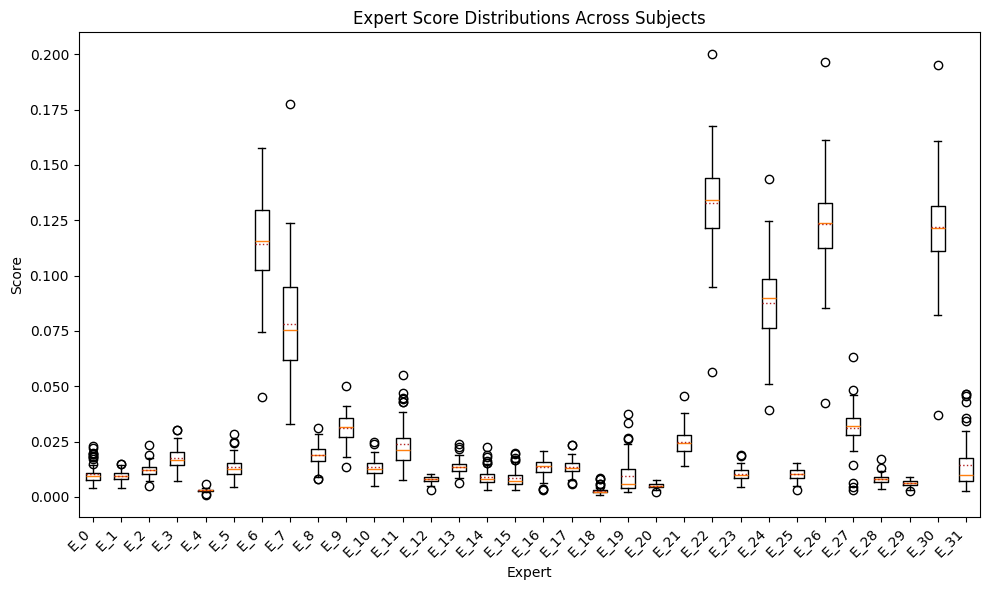

In [5]:
plot_box(df_gpt_oss_domain_specialization)

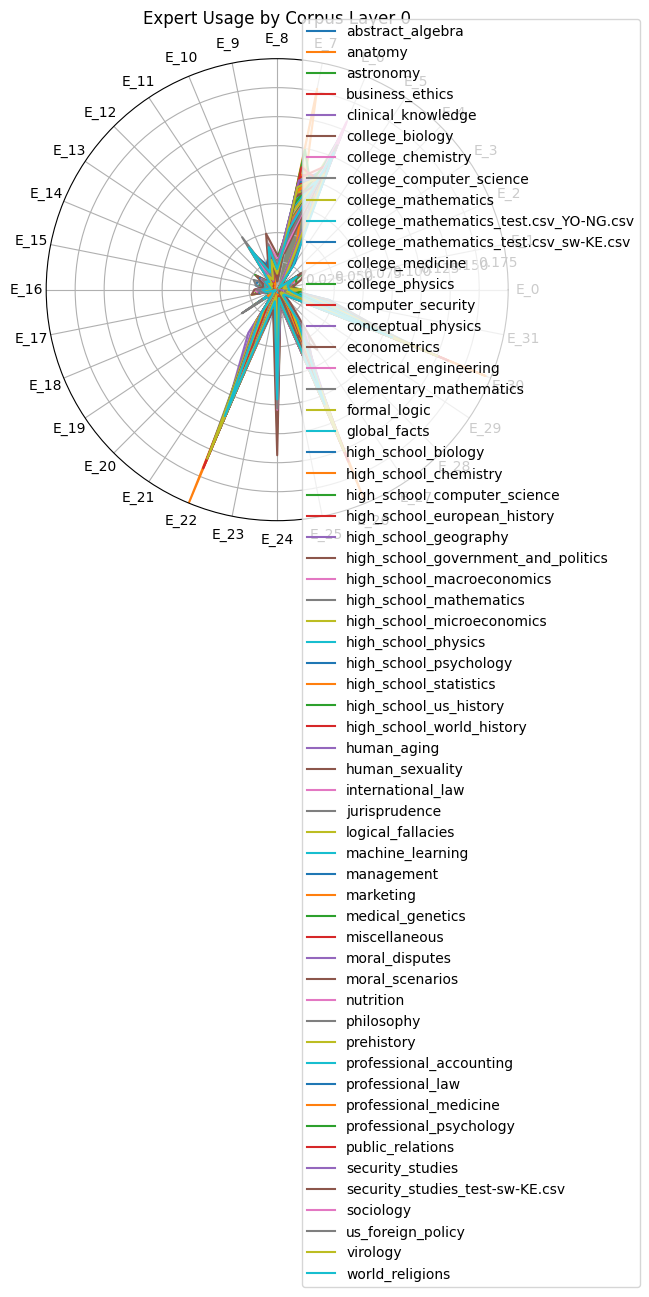

In [6]:
plot_radar(df_gpt_oss_domain_specialization, title="Expert Usage by Corpus Layer 0")

/users/anowak/developer/moe-router-exploration/src/visualize.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


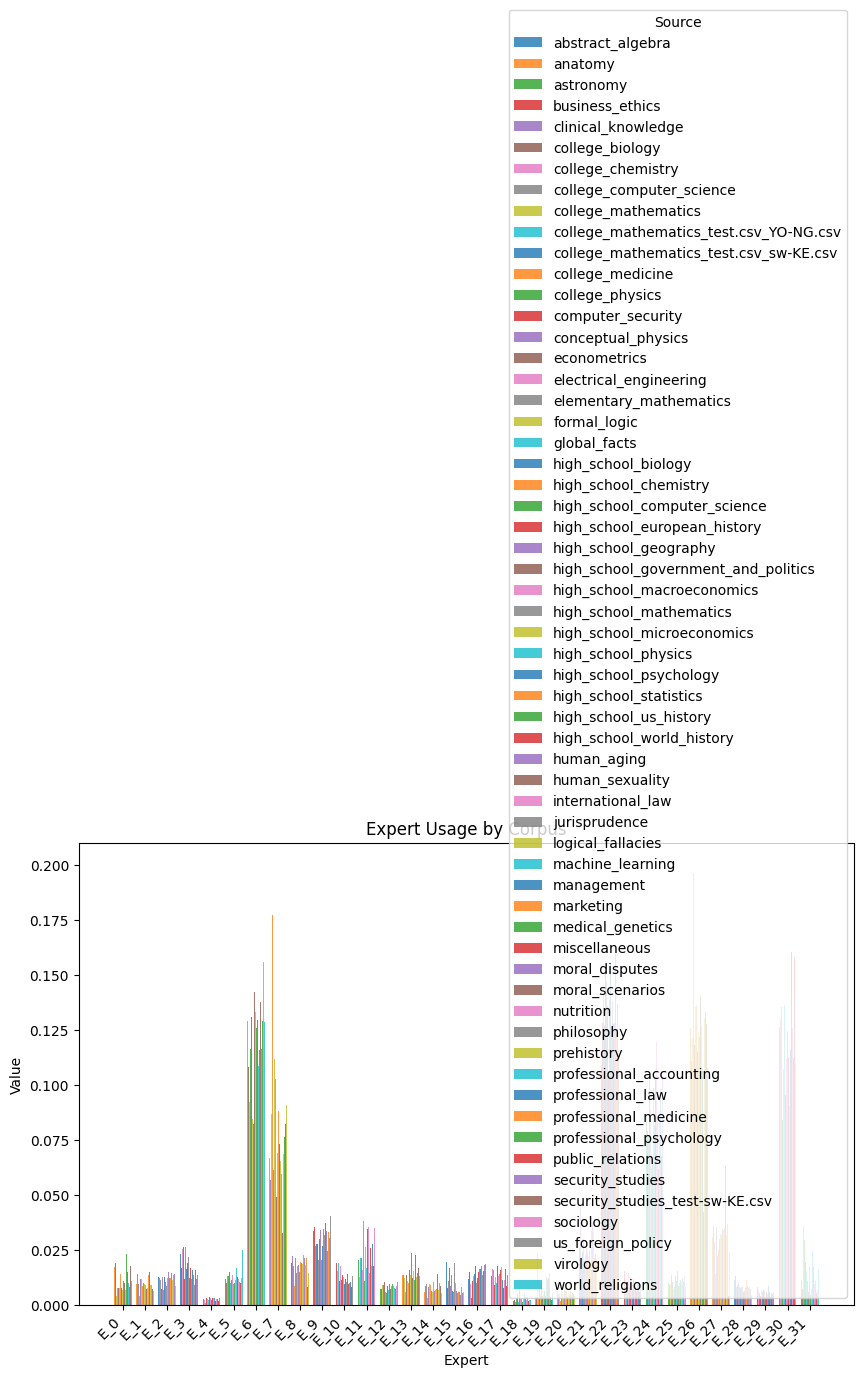

In [7]:
plot_bar(df_gpt_oss_domain_specialization)

## Vocabulary specialization

We define vocabulary specialization as how they do it in OlMoE as the proportion of tokens with a token ID $x$ (also called vocabulary element) that are routed to one particular expert $E_i$ out of all experts in that layer:

$$
\text{Vocabulary specialization}(E_i, x) = \frac{N^{(k)}_{x, E_i}}{N_x}, \quad (8)
$$

where:

- $E_i$: The $i$ th expert in the model.
- $x$: The token ID being analyzed.
- $k$: The number of experts considered (e.g., $k = 8$ means considering the top $8$ experts with the highest routing probabilities).
- $N^{(k)}_{x, E_i}$: The number of times input data is routed to $E_i$ for $x$.
- $N_x$: The total number of times input data is routed across all experts for $x$.

In [8]:
df_gpt_oss_vocabulary_specialization = get_vocabulary_specialization(df_gpt_oss)

In [9]:
df_gpt_oss_vocabulary_specialization.max()

tok_id
0         0.25
1         0.25
2         0.25
3         0.25
4         0.25
          ... 
199993    0.25
199994    0.25
199995    0.25
199997    0.25
199999    0.25
Length: 87030, dtype: float32

In [10]:
df_gpt_oss_expert_topn = get_top_n_tokens_per_expert("openai/gpt-oss-20b", df_gpt_oss, 100, layer=7)


In [11]:
df_gpt_oss_expert_topn

rank,tok_1,tok_2,tok_3,tok_4,tok_5,tok_6,tok_7,tok_8,tok_9,tok_10,...,count_91,count_92,count_93,count_94,count_95,count_96,count_97,count_98,count_99,count_100
E_0,2,1,000,3,0,5,4,10,6,Ġ+,...,1661,1654,1648,1635,1610,1606,1571,1539,1537,1529
E_1,Ġ/,.,",",Ġ,à¥¤,ãĢĤ,Ġ|,1,2,ãĢģ,...,2519,2511,2452,2446,2432,2430,2392,2366,2363,2354
E_2,<|endoftext|>,Ìģ,ÌĢ,Ġya,ãģ®,Ġwa,1,",",Ġde,Ġla,...,1821,1750,1740,1740,1737,1698,1683,1670,1641,1636
E_3,Ġ/,",",Ġde,Ġun,ãģ®,Ġe,2,Ġ,.,Ġuna,...,5179,5178,5175,5102,5087,5031,5016,4962,4914,4910
E_4,Choices,Ãł,i,äºº,èĢħ,à¥ĭà¤Ĥ,ÙĬØ©,Ã²,ÌĢ,Ìģ,...,3459,3456,3389,3286,3256,3230,3218,3218,3207,3200
E_5,Ġ/,<|endoftext|>,:,Choices,Ìģ,ÌĢ,",",Ġ,?Ċ,.,...,5212,5139,5138,5135,5135,5115,5077,5047,5020,4820
E_6,Ġ,Ġla,Ġde,",",ĠÃ¬,Ìģ,.,Ġo,Ġl,Ġun,...,904,901,888,886,869,869,867,863,848,840
E_7,Ġ,",",Ġde,ÌĢ,Ġla,.,Ìģ,áº¹,2,ãģ®,...,2316,2298,2262,2252,2228,2224,2216,2212,2196,2195
E_8,<|endoftext|>,Ġ,",",Qual,Âł,Un,.,La,Ġde,ãģ®,...,837,833,828,808,800,779,773,769,749,748
E_9,Choices,Ġ,láº¹,ario,ÌĢ,ãĤª,ë¦¬,enario,Ã¡rio,ika,...,175,174,173,173,172,172,167,164,164,164


In [12]:
unique_top_tokens_per_expert(df_gpt_oss_expert_topn, 20)

{'E_15': set(),
 'E_26': set(),
 'E_14': {'ëĬĶ', 'ìĿĢ'},
 'E_13': {'?', 'ï¼ŁĊ'},
 'E_10': set(),
 'E_16': {'Ġil'},
 'E_6': {'gb', 'ãĥ³'},
 'E_22': set(),
 'E_2': {'ìĿĺ', 'Ġse', 'ĠÙħÙĨ', 'Ġà¤ķà¥Ģ'},
 'E_25': {'Ã©h', 'ĠìķĬ'},
 'E_8': {'K', 'Ni', 'Ø£ÙĬ'},
 'E_12': {'(', ')(', ')[', 'frac', 'Ġ$', 'Ġ-', 'ĠL'},
 'E_17': {'Ġdel', 'Ġkwa', 'ĠÙģÙĬ'},
 'E_29': {'Ġet', 'Ġund', 'Ġà¤Ķà¤°', 'Ġà¦ıà¦¬à¦Ĥ'},
 'E_21': {'ãĤĭ', 'Ġpara', 'Ġá¹£e'},
 'E_28': set(),
 'E_11': {'^', 'à¤¿à¤ķ', 'à¦°', 'à¦¿à¦ķ', 'à§įà¦°', 'æĢ§', 'ìłģ', 'Ġmor'},
 'E_24': set(),
 'E_18': {'æ¬¡', 'æľĢ', 'Ġ='},
 'E_19': set(),
 'E_27': {'Ġ.'},
 'E_30': {'ãģªãģĦ', 'ëª»', 'Ġnon', 'Ġà¤¨à¤¹à¥Ģà¤Ĥ', 'Ġà¦Ńà§ģà¦²'},
 'E_20': {'202', 'Ìģn', 'ĠnÃ¡Ãł', 'Ġwá»į', 'ĠÃ³', 'Ġá»į'},
 'E_4': {'aji',
  'azione',
  'ia',
  'o',
  'à¥ĭà¤Ĥ',
  'à¦¨',
  'à¦¾',
  'à¦¿',
  'äºº',
  'èĢħ'},
 'E_0': {'100', '12', '20', '9'},
 'E_7': {'k'},
 'E_3': {'Ġdan', 'ĠÃłwá»įn', 'Ġà¦ıà¦ķà¦Łà¦¿'},
 'E_1': set(),
 'E_9': {'List',
  'anyaan',
  'enario',
  'ika',
  'láº¹',
 

In [13]:
df_gpt_oss_expert_top_per_layer = get_top_tokens_by_expert_layer_proportion("openai/gpt-oss-20b", df_gpt_oss, 10)


In [14]:
df_gpt_oss_expert_top_per_layer

rank                      tok_1    prop_1   tok_2    prop_2 tok_3    prop_3  \
E_index layer_id                                                              
E_0     0         <|endoftext|>  0.029805      Ãł  0.017917   çļĦ  0.015222   
        1               Choices  0.042138     ato  0.002854   ãģª  0.002321   
        2                     ,  0.019950     Ġla  0.013290    Ġa  0.013241   
        3         <|endoftext|>  0.650075     Ġde  0.016658   Ġla  0.011406   
        4                     2  0.024571       Ġ  0.011998   Ġde  0.009033   
...                         ...       ...     ...       ...   ...       ...   
E_31    19              Ġà¤¹à¥Ī  0.015246       )  0.010358    ÌĢ  0.007345   
        20              Choices  0.405956  Ġmoral  0.010047   âĢľ  0.004392   
        21                   Ġ/  0.024107       ,  0.013627     .  0.010702   
        22                   Ġ/  0.038623       Ġ  0.027181     :  0.020403   
        23        <|endoftext|>  0.074608      Ġ/  0.021681     ,  0.018086   

rank                      tok_4    prop_4   tok_5    prop_5    tok_6  \
E_index layer_id                                                       
E_0     0                    Ã¬  0.013254     ato  0.013089      Ġwa   
        1                  Ġìŀĺ  0.002142     éģķ  0.002021      ëª»   
        2                   Ġde  0.012417    Ġque  0.009709      Ġun   
        3                     ,  0.011197       .  0.009424       Ġ/   
        4                     .  0.005772     åĲĮ  0.005180  Ġà¦¸à¦®   
...                         ...       ...     ...       ...      ...   
E_31    19                   Ìģ  0.005605      Ãł  0.005185     ÙĬØ©   
        20                 ales  0.002523  ĠMoral  0.002335      å¾·   
        21        <|endoftext|>  0.007904     Ġde  0.007743      ãģ®   
        22                  Ġde  0.016086       .  0.013877        ,   
        23                    .  0.014314       :  0.011801      Ġde   

rank                prop_6    tok_7    prop_7       tok_8    prop_8  \
E_index layer_id                                                      
E_0     0         0.011748       Ãº  0.010864          ti  0.009873   
        1         0.001985     Ġmal  0.001837  Ġà¦Ńà§ģà¦²  0.001822   
        2         0.008084       Ġo  0.006564         ãĢģ  0.006466   
        3         0.006637       Ġl  0.004899           Ġ  0.004115   
        4         0.004440      Ġus  0.004418        ario  0.004076   
...                    ...      ...       ...         ...       ...   
E_31    19        0.004857     Ġkan  0.004183        ÙĭØ§  0.004036   
        20        0.002217  Ġmorali  0.002210        ĠDNA  0.002202   
        21        0.005788  Ġà¤ķà¥ĩ  0.005130         çļĦ  0.005125   
        22        0.011283      ãģ®  0.010351         Ġla  0.009681   
        23        0.010150       ?Ċ  0.009686          Ìģ  0.006202   

rank                      tok_9    prop_9 tok_10   prop_10  
E_index layer_id                                            
E_0     0                    ÃŃ  0.008253    Ġde  0.008103  
        1                    Ø£  0.001776     pr  0.001772  
        2                   Ġle  0.005838   Ġdie  0.005708  
        3                   Ġya  0.004026   Ġder  0.003990  
        4                   ãĤª  0.004060    ìĺ¤  0.004020  
...                         ...       ...    ...       ...  
E_31    19                   ÃŃ  0.003922      i  0.003894  
        20            ĠScenario  0.002202   ĠUSA  0.002200  
        21                  Ġla  0.004877    à¥¤  0.004798  
        22        <|endoftext|>  0.008686    çļĦ  0.005692  
        23                  à¥¤  0.005973    ãģ®  0.005971  

[768 rows x 20 columns]

In [15]:
df_gpt_oss_nunique_toks_per_expert = get_amount_unique_tokens_per_expert(df_gpt_oss)

In [16]:
df_gpt_oss_nunique_toks_per_expert

,distinct_token_count
expert_id,
E_0,26387
E_1,5231
E_2,33422
E_3,36474
E_4,5065
E_5,52722
E_6,63268
E_7,9213
E_8,19218


In [9]:
get_total_tokens_per_expert(df_gpt_oss)

,total_token_count,proportion
expert_id,,
E_0,2040405.0,0.010121
E_1,1816472.0,0.009010
E_2,2695882.0,0.013373
E_3,3373119.0,0.016732
E_4,598748.0,0.002970
E_5,2086805.0,0.010351
E_6,22575180.0,0.111981
E_7,17197756.0,0.085307
E_8,4072977.0,0.020204


In [17]:
df_gpt_oss_nunique_toks_per_expert_layer = get_amount_unique_tokens_per_expert_per_layer(df_gpt_oss)

In [18]:
df_gpt_oss_nunique_toks_per_expert_layer

layer_id,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
E_0,0.039823,0.077331,0.044526,0.036871,0.033258,0.015434,0.031583,0.017419,0.039545,0.061605,...,0.022506,0.079809,0.054039,0.034414,0.015108,0.044059,0.064640,0.037746,0.043490,0.035987
E_1,0.005801,0.071370,0.015208,0.015058,0.026469,0.050159,0.030130,0.032619,0.035295,0.065867,...,0.080986,0.043456,0.069575,0.010279,0.095434,0.051264,0.079355,0.010963,0.034855,0.023774
E_2,0.043404,0.051774,0.011113,0.079541,0.004436,0.011070,0.034696,0.034596,0.047789,0.051924,...,0.002599,0.036599,0.110256,0.042102,0.016667,0.008000,0.063129,0.016212,0.065817,0.093860
E_3,0.050936,0.007865,0.033724,0.024500,0.039565,0.042612,0.085274,0.066031,0.029091,0.047374,...,0.020434,0.007719,0.067569,0.103824,0.049987,0.049943,0.016186,0.046431,0.022700,0.019449
E_4,0.006437,0.017057,0.095504,0.031869,0.043951,0.026645,0.047941,0.069547,0.025273,0.024599,...,0.074604,0.060819,0.082673,0.021981,0.010376,0.020945,0.075082,0.103979,0.012721,0.075835
E_5,0.057149,0.025491,0.078107,0.032674,0.024229,0.027049,0.043717,0.056949,0.009027,0.065179,...,0.023601,0.041048,0.010499,0.092420,0.009220,0.014447,0.080780,0.045238,0.008593,0.003806
E_6,0.082317,0.011544,0.022307,0.010891,0.052738,0.103830,0.043343,0.054159,0.055032,0.008608,...,0.112300,0.019357,0.000589,0.012388,0.019078,0.111000,0.025028,0.015511,0.008223,0.060794
E_7,0.011793,0.034025,0.006673,0.014333,0.088045,0.023429,0.095025,0.066161,0.008094,0.038044,...,0.062764,0.018322,0.042500,0.097250,0.008419,0.053559,0.001667,0.007003,0.074953,0.035227
E_8,0.029137,0.012811,0.012907,0.042835,0.042157,0.029716,0.008160,0.042998,0.064245,0.103974,...,0.077098,0.080884,0.035612,0.021057,0.014779,0.044995,0.008179,0.025064,0.022018,0.019943
E_9,0.098683,0.007733,0.031662,0.023647,0.015576,0.031501,0.032090,0.026713,0.108426,0.017024,...,0.031568,0.095432,0.003521,0.024663,0.029949,0.090995,0.063474,0.080878,0.059908,0.024141


## Language Specialization

We define language specialization as the proportion of tokens from a specific language that are routed to one particular expert $E_i$ out of all experts in that layer:

$$
\text{Language specialization}(E_i, L) = \frac{N^{(k)}_{E_i, L}}{N_L}, \quad (8)
$$

where:

- $E_i$: The $i$ th expert in the model.
- $L$: The language.
- $k$: The number of experts considered (e.g., $k = 8$ means considering the top $8$ experts with the highest routing probabilities).
- $N^{(k)}_{E_i, L}$: The number of tokens of language $L$ that are routed to the expert $i$.
- $N_L$: The total number of tokens of language $L$ that are processed by the MoE.

In [ ]:
df_gpt_oss_language_specialization = get_language_specialization(df_gpt_oss, layer=0)

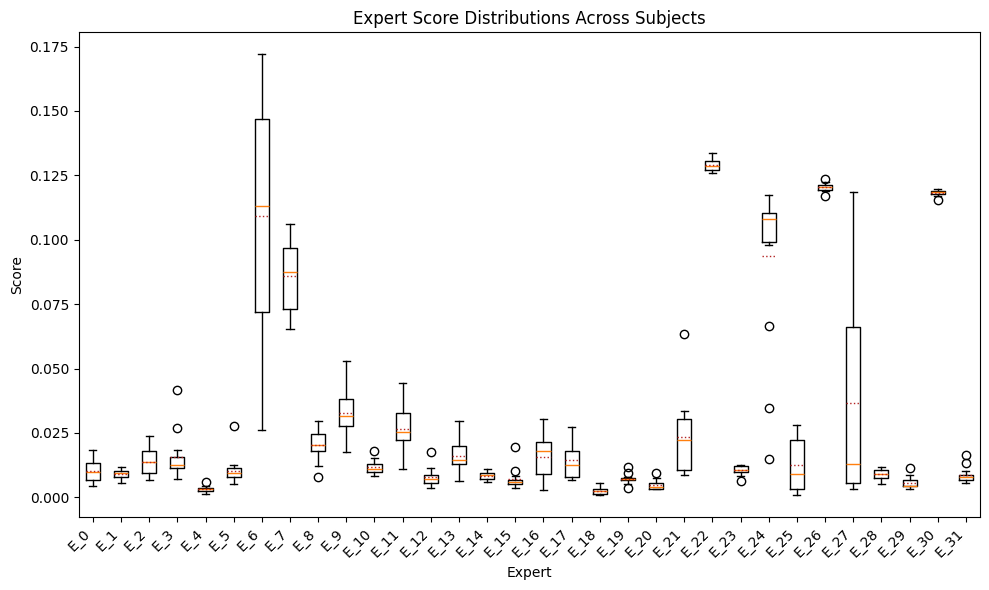

In [20]:
plot_box(df_gpt_oss_language_specialization)

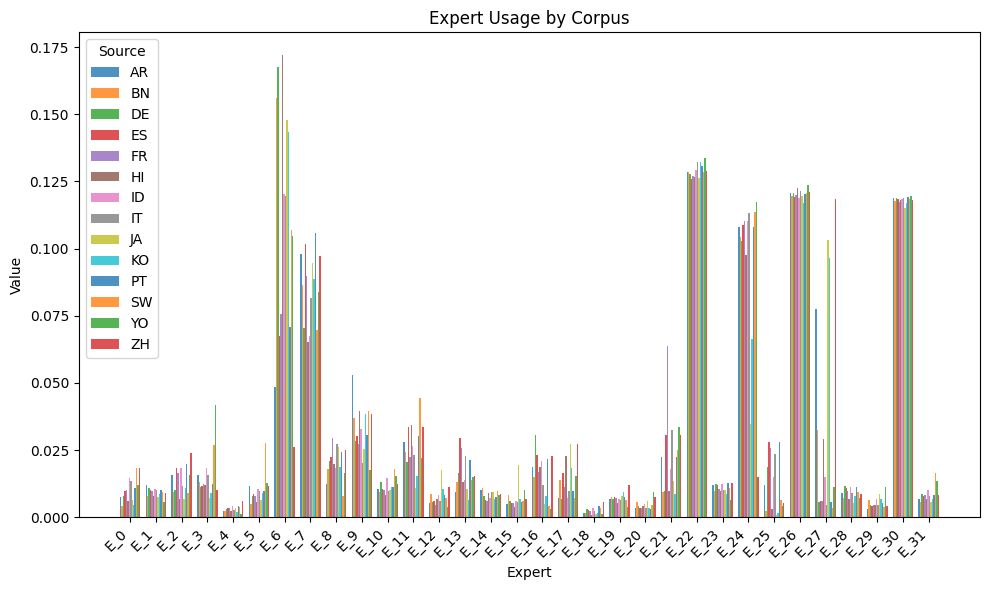

In [21]:
plot_bar(df_gpt_oss_language_specialization)

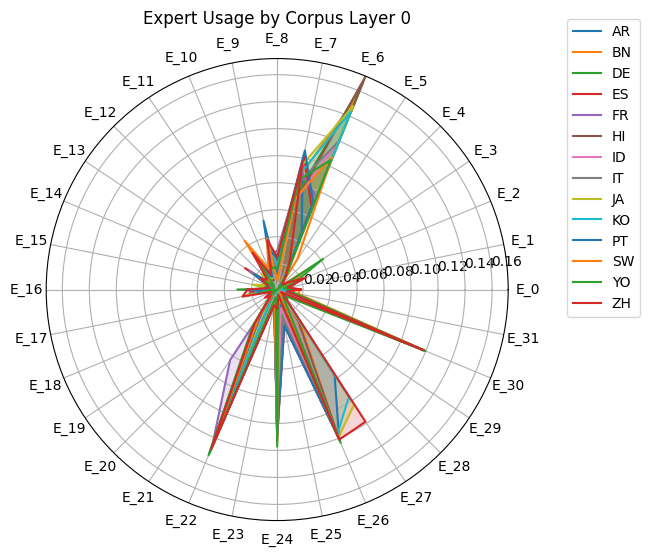

In [22]:
plot_radar(df_gpt_oss_language_specialization, title="Expert Usage by Corpus Layer 0")

In [25]:
df_gpt_oss_language_specialization.head()

language,AR,BN,DE,ES,FR,HI,ID,IT,JA,KO,PT,SW,YO,ZH
E_0,0.007499,0.004269,0.007864,0.009673,0.010057,0.006060,0.014666,0.013526,0.006282,0.004399,0.010718,0.018264,0.012087,0.018351
E_1,0.011955,0.007796,0.010671,0.010221,0.009678,0.007827,0.010594,0.010171,0.007643,0.008742,0.010083,0.009392,0.005727,0.008964
E_2,0.015630,0.009209,0.010109,0.018352,0.016532,0.006635,0.018412,0.011733,0.006875,0.011001,0.019714,0.008941,0.015508,0.023866
E_3,0.015592,0.012910,0.011383,0.011767,0.012395,0.012053,0.018256,0.015877,0.007295,0.009014,0.012494,0.027035,0.041748,0.010246
E_4,0.002197,0.002384,0.002886,0.003272,0.003277,0.002437,0.004304,0.002568,0.003420,0.001765,0.004143,0.003770,0.001181,0.005970


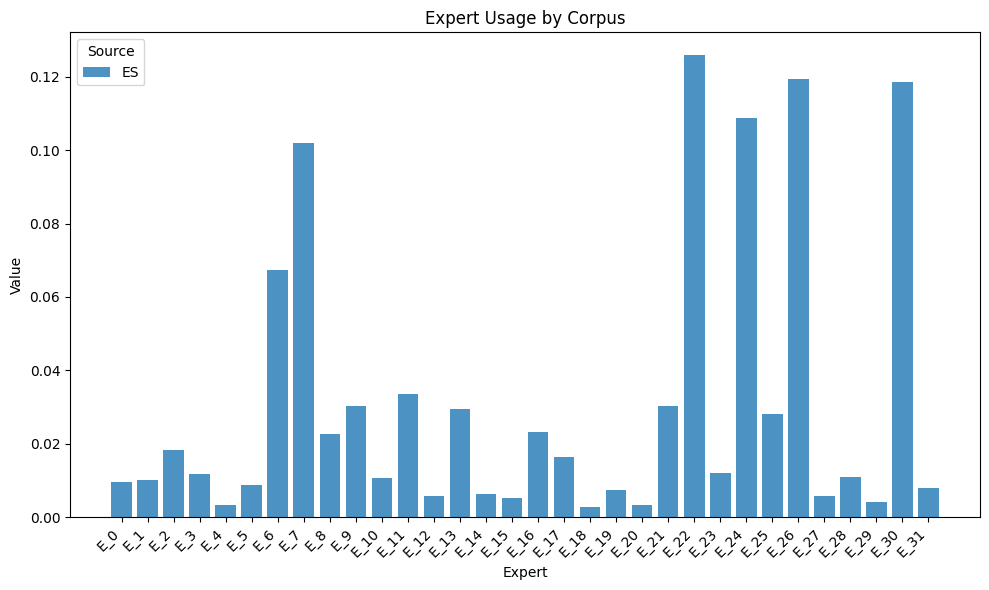

In [33]:
plot_bar(df_gpt_oss_language_specialization[["ES"]])

# DeepSeek-MoE

In [ ]:
root_path = (
    "$SCRATCH/moe-router-exploration-data/deepseek-ai-deepseek-moe-16b-base/cais-mmlu"
)
root_path = os.path.expandvars(root_path)

df_deepseek_moe = create_dataset_routing_statisitcs_dataframe(root_path)

In [63]:
df_deepseek_moe_topn = get_top_n_tokens_per_expert(
    "deepseek-ai/deepseek-moe-16b-base", df_deepseek_moe, 20
)

In [64]:
df_deepseek_moe_topn

rank,tok_1,tok_2,tok_3,tok_4,tok_5,tok_6,tok_7,tok_8,tok_9,tok_10,...,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_18,count_19,count_20
E_0,<｜end▁of▁sentence｜>,Ġthe,Ġ,Ġ/,Ġof,0,Ġto,",",Ġa,Ġis,...,21451,21129,20371,19558,18413,17624,14166,14118,13593,12694
E_1,<｜end▁of▁sentence｜>,Ġthe,.,Ġ/,Ġof,Ġ,Ġa,",",Ċ,:,...,28967,28332,27302,25942,25640,25584,22359,20578,19254,17771
E_2,<｜end▁of▁sentence｜>,.,Ġ/,Ġ,0,Ġthe,Ġof,Ċ,",",<｜begin▁of▁sentence｜>,...,30907,29747,27019,26788,26380,21531,20681,19391,18683,16979
E_3,<｜end▁of▁sentence｜>,Ġthe,.,0,Ġof,Ġis,ices,",",Ġ,<｜begin▁of▁sentence｜>,...,21096,19901,19037,16179,16139,14439,11441,10704,10696,10538
E_4,<｜end▁of▁sentence｜>,Ġthe,Ġof,0,Ġ,Ġis,1,2,Ġ/,Ġa,...,24258,24073,23712,23448,19266,17990,16993,16016,14729,14166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E_59,<｜end▁of▁sentence｜>,Ġ,Ġ/,.,Ġis,:,Ġof,<｜begin▁of▁sentence｜>,",",0,...,31934,25820,25576,23876,19520,18710,17815,14218,12883,12841
E_60,<｜end▁of▁sentence｜>,.,Ġ/,Ġthe,Ġof,",",:,Ġis,Ġto,Ċ,...,25153,23291,21154,20205,19833,17396,12434,10724,9150,8910
E_61,<｜end▁of▁sentence｜>,Ġ/,.,",",Ġand,<｜begin▁of▁sentence｜>,Ġthe,Ġto,Ġ,Ġof,...,24871,24498,16070,15770,13319,13308,11136,10204,9902,9321
E_62,<｜end▁of▁sentence｜>,.,Ġthe,Ġ,Ġ/,Ġof,Ċ,",",0,<｜begin▁of▁sentence｜>,...,27935,27826,24823,23231,22784,18698,18565,18465,17246,16614


In [65]:
unique_top_tokens_per_expert(df_deepseek_moe_topn, n=10)

{'E_15': set(),
 'E_58': set(),
 'E_48': set(),
 'E_27': set(),
 'E_2': set(),
 'E_50': set(),
 'E_47': set(),
 'E_22': set(),
 'E_5': set(),
 'E_61': set(),
 'E_19': set(),
 'E_43': set(),
 'E_24': set(),
 'E_20': set(),
 'E_30': set(),
 'E_17': set(),
 'E_11': set(),
 'E_57': set(),
 'E_21': set(),
 'E_6': set(),
 'E_29': set(),
 'E_52': set(),
 'E_12': set(),
 'E_39': set(),
 'E_28': set(),
 'E_0': set(),
 'E_7': set(),
 'E_35': set(),
 'E_13': set(),
 'E_33': set(),
 'E_56': set(),
 'E_44': set(),
 'E_31': set(),
 'E_46': set(),
 'E_9': set(),
 'E_59': set(),
 'E_34': set(),
 'E_42': set(),
 'E_36': set(),
 'E_3': set(),
 'E_40': set(),
 'E_37': set(),
 'E_16': set(),
 'E_4': {'2'},
 'E_54': set(),
 'E_23': set(),
 'E_60': set(),
 'E_32': set(),
 'E_26': set(),
 'E_10': set(),
 'E_55': set(),
 'E_53': set(),
 'E_41': set(),
 'E_62': set(),
 'E_25': set(),
 'E_51': set(),
 'E_38': set(),
 'E_1': set(),
 'E_18': set(),
 'E_45': set(),
 'E_14': {'?'},
 'E_8': set(),
 'E_49': set(),
 '